# EDS232 Lab 1: Regression

## Overview
In this lab, we will introduce the basics of machine learning in **Python** with **regression** algorithms, a core technique used to predict continuous outcomes. We will use the popular **scikit-learn** library, which provides easy-to-use tools for building and evaluating machine learning models.

Specifically, we will learn how regression algorithms can help us model and predict water quality data.

## Objectives
By the end of this lab, you will be able to:
- Understand the concept of regression 
- Implement regression models in Python
- Evaluate model performance using  **R²** and **MSE**
- Visualize regression prediction results 

## Key Concepts

- **Regression**: A machine learning method for predicting continuous values.
  - **Simple Linear Regression**: A regression model with one independent variable.
  - **Polynomial Regression**: A regression model which models the relationship between X and Y as an n-degree polynomial.
  
- **Scikit-learn**: A Python library that provides simple and efficient tools for data mining and machine learning. We will use it for:
  - **Data Preprocessing**: Preparing data for the model.
  - **Model Training**: Fitting the regression model to our data.
  - **Model Evaluation**: Assessing model performance using model evaluation metrics.

- **Model Evaluation Metrics**: Tools to assess how well our model fits the data, such as:
  - **R² (R-squared)**: Measures the proportion of variance in the dependent variable that is predictable from the independent variable(s).
  - **MSE (Mean Square Error)**: The average squared differences between predicted and actual values.



### About the data

Hurricane Irene caused extensive flood and wind damage as it traveled across the Caribbean and up the East coast of the United States.  The Hurricane made landfall in the United States near Cape Lookout, North Carolina on August 27th, 2011 and was downgraded to a Tropical Storm by the time it hit the New York City region on Sunday, August 28th, 2011.

A dataset from the Hudson River Environmental Conditions Observing System (HRECOS) offers a detailed look at the effects of Hurricane Irene on the river's ecosystem through high-frequency, 15-minute interval measurements over a ten-day period. It includes variables critical to understanding ecological health, such as water temperature, dissolved oxygen, turbidity, depth, and meteorological data like rainfall and wind speed. Analyzing these variables helps answer questions about how extreme weather events like hurricanes can disrupt river ecosystems and impact water quality.
**You can access the data and metadata [here](https://www.caryinstitute.org/eco-inquiry/hudson-data-jam-competition/datasets/hurricane-irene-and-hudson-river).**

### Step 1: Import libraries and load data


#### Load libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.linear_model
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(42)

#### Load the data

Turbidity levels in water can be significantly affected by major weather events such as hurricanes. Turbidity measures how much light is blocked by particles in water. In an event like a hurricane, we expect wind and rainfall to bring in suspended particles, increasing the turbidity of the water. When light is blocked by particles in water, oxygen production is impacted as well. When a natural disaster like a hurricane alters turbidity levels in a body of water, how is dissolved oxygen  impacted? Let's find out. 

In this lab, we are interested in the turbidity and dissolved oxygen variables. Read the data into the `hurricane_do` and `hurricane_turbidity` variables. Then, merge these two dataframes. Store the result in the `df` variable. Drop the columns that contain data for Piermont, as Piermont does not contain any turbidity data. We are only interested in the Port of Albany and Norrie Point for this lab. 

*Notice that the data is not a csv file and is instead a **.xlsx** file! Use the `pandas.read_excel` function to read in your data. You can find more documentation on reading in .xlsx files [here](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html).*

In [41]:
hurricane_do = pd.read_csv('data/do_hurricane.csv')
hurricane_turbidity = pd.read_csv('data/turbidity.csv')
df = pd.merge(hurricane_do, hurricane_turbidity)
df.columns
df = df.drop(columns=['Piermont D.O. (ppm)','Piermont Turbidity in NTU'])
df.head(5)
df.columns

Index(['Date Time (ET)', ' Port of Albany D.O. (ppm)',
       'Norrie Point D.O. (ppm)', ' Port of Albany Turbidity in NTU',
       'Norrie Point Turbidity in NTU'],
      dtype='object')

### Step 2: Explore  and clean the data

Do some initial exploratory analysis on the data. Check out what type of data you are working with, and plot your data. Write a few sentences on your findings. 

In [47]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
# pd.to_datetime(df['date_time_(et)'])
df.dtypes

date_time_(et)                      object
port_of_albany_d.o._(ppm)          float64
norrie_point_d.o._(ppm)            float64
port_of_albany_turbidity_in_ntu    float64
norrie_point_turbidity_in_ntu      float64
dtype: object

<Axes: >

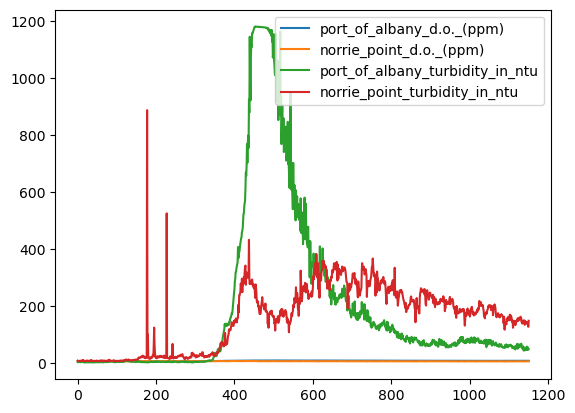

In [46]:
df.plot()

*Update this markdown cell with your findings.* 

When you were exploring the data, you may have noticed that the column names aren't the cleanest. Update the column names to the following : `date`, `albany_DO`, `norrie_DO`, `albany_turbidity`, `norrie_turbidity` (**make sure your column names are in that order!!**). 

In [54]:
df.columns
new_columns = ['date','albany_DO','norrie_DO','albany_turbidity','norrie_turbidity']
df.columns = new_columns
df # Check to make sure column names were updated

,date,albany_DO,norrie_DO,albany_turbidity,norrie_turbidity
0,8/25/11 0:00,7.68,7.81,4.0,9.3
1,8/25/11 0:15,7.60,7.73,3.9,8.4
2,8/25/11 0:30,7.57,7.63,4.3,7.9
3,8/25/11 0:45,7.72,7.67,4.7,8.1
4,8/25/11 1:00,7.74,7.63,4.4,8.4
...,...,...,...,...,...
1147,9/5/11 22:45,8.73,6.84,47.2,144.1
1148,9/5/11 23:00,8.76,6.78,56.7,139.7
1149,9/5/11 23:15,8.66,6.83,47.0,141.2
1150,9/5/11 23:30,8.75,6.79,48.7,127.9


### Step 3: Prepare the data for machine learning

It is time to split our data into training and testing data for our linear regression model. The `train_test_split` function from the `sklearn.model_selection` module will let us accomplish this.

The `train_test_split` function takes two inputs: X and Y, and produces four outputs: X_train, X_test, Y_train, and Y_test.  It also takes two parameters, `test_size`, which specifies the proportion of data to be used in the testing set and `random_state`.

This process allows us to train the model on a subset of the data (training set) and then evaluate its performance and generalizability on unseen data (testing set). By doing this, we can assess how well the model predicts dissolved oxygen levels based on turbidity after a storm. 

Select your data such that `albany_turbidity` is your feature or independent variable (X) and `albany_DO` is your target or dependent variable (Y). Then split it using `train_test_split`.

 **Use a test size of 0.33 and a random state of 42**. 

In [ ]:
# Select features and target
X = ...
Y = ...

X_train, X_test, Y_train, Y_test = ... 

### Step 4: Select your model

We are going to use linear regression to predict the turbidity in Albany. Is linear regression a good model to pick to achieve this goal? Answer in the markdown cell below.

*Your answer here*.

In [ ]:
# Initialize and fit the model
model = ...


### Step 5: Evaluate the model

Now it's time to see how well our model does on this task.  To accomplish this, make predictions with your model on the test data and then check its performance by examining the MSE and the $R^2$ score. Because we held the test data out from the training process, these predictions give us an idea of how our model performs on unseen data. Then visualize your model's performance by creating a scatter plot of the Y predictions and your Y test data. 

In [ ]:
# Make predictions
Y_pred = ...

# Calculate evaluation metrics using scikit-learn's mean_squared_error and r2_score
mse = ...
r2 = ...

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Visualize predictions vs. actual values


### Step 6:  Present the Solution
In the markdown cell below, discuss how your model performed overall. If the model performed poorly, why do you think it did so? If it performed well, why do you think it did so? What could future analysis include? 

*Your answer here.*

#### *Before we selected our algorithm, we should have looked at the data for evidence of a linear relationship between variables. Let's check now!*

In [ ]:
plt.figure(figsize=(10, 6))  # Setting the figure size for better visibility
df.plot.scatter(x='albany_DO', y='albany_turbidity', c='DarkBlue')

plt.title('Turbidity vs. Dissolved Oxygen at Port of Albany')
plt.xlabel('Dissolved Oxygen (ppm)')
plt.ylabel('Turbidity (NTU)')
plt.grid(True)
plt.show()

### Step 7: Check to see if polynomial regression performs better

We assumed linear regression would work well with our data, but this data doesn't look very linear. It's a good reminder of the importance of exploratory analysis. Let's check to see how a polynomial regression performs in comparison. Transform the features for polynomial regression. Use the `PolynomialFeatures` class from the `sklearn.preprocessing` module. 

In [ ]:
# Transform features to include polynomial terms (degree 2 for quadratic terms)
poly = ...
X_poly_train = ...
X_poly_test = ...

# View the transformed feature set (for insight)
print(X_poly_train)

### Step 8: Fit your model on the polynomial features

In [ ]:
# Train the model on polynomial features 
poly_model = ...


### STEP 9: Evaluate the polynomial regression model 
- Make predictions with your model and then check the performance of the model.
- Check your model performance by looking at the MSE and the $R^2$ score.
- Create a scatter plot of the Y polynomial predictions and your Y test data.

In [ ]:
# Make predictions using the polynomial model
Y_poly_pred = ...

# Calculate evaluation metrics using scikit-learn's mean_squared_error and r2_score
poly_mse = ...
poly_r2 = ...

print(f"Polynomial Regression Mean Squared Error: {poly_mse}")
print(f"Polynomial Regression R² Score: {poly_r2}")

# Plot predictions vs actual


### Step 10: Compare your polynomial and linear regression results

What differences did you notice between you polynomial regression and linear regression results? Which model performed better? Why do you think this is? Write your answer in the markdown cell below. 

*Your answer here.*